In [1]:
import pandas as pd
import numpy as np
import math
from time import time
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
from sklearn.preprocessing import StandardScaler
import regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from itertools import combinations


## Loading Superconductors dataset

In [2]:
df = pd.read_csv('superconductors.csv')

Heatmap

In [3]:
vif_data=df.drop(['critical_temp'], axis=1)

#print(f'Il VIF Massimo è {m}, corrspondente alla {m_idx}-iesima feature')
vif=pd.DataFrame()
vif['VIF'] = np.linalg.inv(vif_data.corr()).diagonal()
vif['Features'] = vif_data.columns
selected = []
for i in range(41): 
    m_idx=vif['VIF'].idxmax()
    selected.append(vif['Features'][m_idx])
    vif= vif.drop([m_idx])
    del m_idx

df_selected = df.drop(selected, axis=1)
print(df_selected.shape)

(21263, 41)


In [4]:
class SBS():
    def __init__(self, estimator, k_features, scoring=r2_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

## Preprocessing

#### Creating data for traininig, validation and testing

In [5]:
X, y = df.iloc[:, :81].values, df.iloc[:, 81].values
# Holdout. Dividing dataset in two subsets: training and test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

Variance

In [88]:
df_vt=df.drop(['critical_temp'], axis=1)
var_thr = VarianceThreshold(threshold=1) #Removing both constant and quasi-constant
var_thr.fit(df_vt)
concol = [column for column in df_vt.columns if column not in df_vt.columns[var_thr.get_support()]]
for features in concol:
    print(features)
df_vt=df_vt.drop(concol,axis=1)
df_vt.shape

entropy_atomic_mass
wtd_entropy_atomic_mass
entropy_fie
wtd_entropy_fie
entropy_atomic_radius
wtd_entropy_atomic_radius
entropy_Density
wtd_entropy_Density
entropy_ElectronAffinity
wtd_entropy_ElectronAffinity
entropy_FusionHeat
wtd_entropy_FusionHeat
entropy_ThermalConductivity
wtd_entropy_ThermalConductivity
entropy_Valence
wtd_entropy_Valence
wtd_range_Valence
std_Valence
wtd_std_Valence


(21263, 62)

In [89]:
X_v, y_v = df_vt.iloc[:, :-1].values, df.iloc[:, -1:].values
# Holdout. Dividing dataset in two subsets: training and test.
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X_v, y_v, test_size=0.20, random_state=1)

sc = StandardScaler()
X_train_std_v = sc.fit_transform(X_train_v)
X_test_std_v = sc.transform(X_test_v)
print(len(X_v[0]),len(y_v[0]))


61 1


In [90]:
lr = LinearRegression()
t_0 = time()
lr.fit(X_train_std_v, y_train_v)
RT_lr = time()-t_0

y_train_pred = lr.predict(X_train_std_v)
y_test_pred = lr.predict(X_test_std_v)
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train_v, y_train_pred),
                                       mean_squared_error(y_test_v, y_test_pred)))
print('RMSE. train: %.3f, test: %.3f' % (math.sqrt(mean_squared_error(y_train_v, y_train_pred)),
                                       math.sqrt(mean_squared_error(y_test_v, y_test_pred))))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train_v, y_train_pred), r2_score(y_test_v, y_test_pred)))
RT_lr

MSE train: 325.531, test: 333.857
RMSE. train: 18.042, test: 18.272
R^2 train: 0.723, test: 0.713


0.06499505043029785

In [91]:
forest = RandomForestRegressor(n_estimators=10,max_depth=15, criterion='squared_error', random_state=1, n_jobs=-1)
t_0= time()
forest.fit(X_train_v, y_train_v)
RT_forest = time()-t_0
y_train_pred = forest.predict(X_train_v)
y_test_pred = forest.predict(X_test_v)

print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train_v, y_train_pred),
                                       mean_squared_error(y_test_v, y_test_pred)))
print('RMSE. train: %.3f, test: %.3f' % (math.sqrt(mean_squared_error(y_train_v, y_train_pred)),
                                       math.sqrt(mean_squared_error(y_test_v, y_test_pred))))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train_v, y_train_pred), r2_score(y_test_v, y_test_pred)))
print('Running Time:', RT_forest)

C:\Users\lipar\AppData\Local\Temp/ipykernel_10608/2294197109.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train_v, y_train_v)


MSE train: 37.905, test: 97.774
RMSE. train: 6.157, test: 9.888
R^2 train: 0.968, test: 0.916
Running Time: 1.292081356048584


SBS

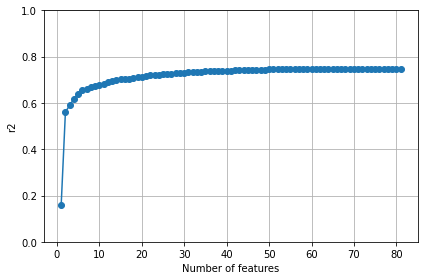

In [92]:
linr = LinearRegression()

# selecting features
sbs = SBS(linr, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0, 1.
         ])
plt.ylabel('r2')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

In [93]:
k3 = list(sbs.subsets_[50])
print(df.columns[k3])
print(k3)

Index(['mean_atomic_mass', 'wtd_mean_atomic_mass', 'wtd_gmean_atomic_mass',
       'entropy_atomic_mass', 'range_atomic_mass', 'std_fie',
       'mean_atomic_radius', 'wtd_mean_atomic_radius',
       'wtd_gmean_atomic_radius', 'wtd_entropy_atomic_radius',
       'range_atomic_radius', 'std_atomic_radius', 'mean_Density',
       'wtd_entropy_Density', 'wtd_mean_ElectronAffinity',
       'wtd_gmean_ElectronAffinity', 'range_ElectronAffinity',
       'std_ElectronAffinity', 'wtd_std_ElectronAffinity',
       'wtd_mean_FusionHeat', 'wtd_gmean_FusionHeat', 'wtd_entropy_FusionHeat',
       'wtd_range_FusionHeat', 'wtd_mean_ThermalConductivity',
       'wtd_gmean_ThermalConductivity', 'range_ThermalConductivity',
       'wtd_range_ThermalConductivity', 'std_ThermalConductivity',
       'wtd_entropy_Valence', 'range_Valence', 'wtd_std_Valence'],
      dtype='object')
[1, 2, 4, 5, 7, 19, 21, 22, 24, 26, 27, 29, 31, 36, 42, 44, 47, 49, 50, 52, 54, 56, 58, 62, 64, 67, 68, 69, 76, 77, 80]


## Regression Models

#### Simple Linear Regression

In [94]:
lr = LinearRegression()
t_0 = time()
lr.fit(X_train_std, y_train)
RT_lr = time()-t_0

y_train_pred = lr.predict(X_train_std)
y_test_pred = lr.predict(X_test_std)
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                                       mean_squared_error(y_test, y_test_pred)))
print('RMSE. train: %.3f, test: %.3f' % (math.sqrt(mean_squared_error(y_train, y_train_pred)),
                                       math.sqrt(mean_squared_error(y_test, y_test_pred))))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train: 306.076, test: 318.278
RMSE. train: 17.495, test: 17.840
R^2 train: 0.740, test: 0.726


In [95]:
lr = LinearRegression()
t_0 = time()
lr.fit(X_train_std[:, k3], y_train)
RT_lr = time()-t_0

y_train_pred = lr.predict(X_train_std[:, k3])
y_test_pred = lr.predict(X_test_std[:, k3])
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                                       mean_squared_error(y_test, y_test_pred)))
print('RMSE. train: %.3f, test: %.3f' % (math.sqrt(mean_squared_error(y_train, y_train_pred)),
                                       math.sqrt(mean_squared_error(y_test, y_test_pred))))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))
RT_lr

MSE train: 326.403, test: 336.533
RMSE. train: 18.067, test: 18.345
R^2 train: 0.722, test: 0.710


0.042574405670166016

## Non Linear Regression

#### Decision Tree

In [96]:
tree = DecisionTreeRegressor(max_depth=12)
t_0= time()
tree.fit(X_train, y_train)
RT_tree = time()-t_0

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
#print(ridge.coef_)
print('Ridge MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                                             mean_squared_error(y_test, y_test_pred)))
print('RMSE. train: %.3f, test: %.3f' % (math.sqrt(mean_squared_error(y_train, y_train_pred)),
                                       math.sqrt(mean_squared_error(y_test, y_test_pred))))
print('Ridge R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

Ridge MSE train: 71.745, test: 152.380
RMSE. train: 8.470, test: 12.344
Ridge R^2 train: 0.939, test: 0.869


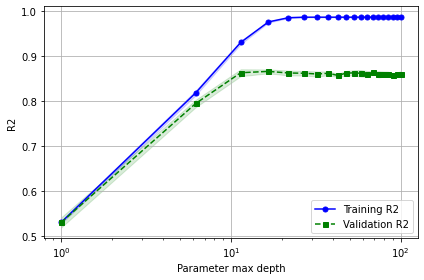

In [11]:
param_range = np.linspace(1, 100, 20)
train_scores, test_scores = validation_curve(estimator=DecisionTreeRegressor(), X=X_train, y=y_train,
                                             param_name='max_depth', param_range=param_range, cv=5,
                                            scoring='r2')

train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
test_mean, test_std  = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training R2')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='Validation R2')
plt.fill_between(param_range, test_mean + test_std,test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter max depth')
plt.ylabel('R2')
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()

In [12]:
tree = DecisionTreeRegressor(max_depth=12)
t_0= time()
tree.fit(X_train[:, k3], y_train)
RT_tree = time()-t_0

y_train_pred = tree.predict(X_train[:, k3])
y_test_pred = tree.predict(X_test[:, k3])
#print(ridge.coef_)
print('Ridge MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                                             mean_squared_error(y_test, y_test_pred)))
print('RMSE. train: %.3f, test: %.3f' % (math.sqrt(mean_squared_error(y_train, y_train_pred)),
                                       math.sqrt(mean_squared_error(y_test, y_test_pred))))
print('Ridge R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

Ridge MSE train: 230.790, test: 254.469
RMSE. train: 15.192, test: 15.952
Ridge R^2 train: 0.804, test: 0.781


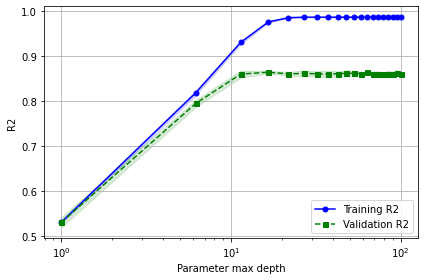

In [13]:
param_range = np.linspace(1, 100, 20)
train_scores, test_scores = validation_curve(estimator=DecisionTreeRegressor(), X=X_train, y=y_train,
                                             param_name='max_depth', param_range=param_range, cv=5,
                                            scoring='r2')

train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
test_mean, test_std  = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training R2')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='Validation R2')
plt.fill_between(param_range, test_mean + test_std,test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter max depth')
plt.ylabel('R2')
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()

#### Random Forest

In [21]:
forest = RandomForestRegressor(n_estimators=10,max_depth=15, criterion='squared_error', random_state=1, n_jobs=-1)
t_0= time()
forest.fit(X_train, y_train)
RT_forest = time()-t_0
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                                       mean_squared_error(y_test, y_test_pred)))
print('RMSE. train: %.3f, test: %.3f' % (math.sqrt(mean_squared_error(y_train, y_train_pred)),
                                       math.sqrt(mean_squared_error(y_test, y_test_pred))))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))
print('Running Time:', RT_forest)

MSE train: 37.101, test: 98.283
RMSE. train: 6.091, test: 9.914
R^2 train: 0.968, test: 0.915
Running Time: 1.8061697483062744


In [19]:
forest = RandomForestRegressor(n_estimators=10,max_depth=16, criterion='squared_error', random_state=1, n_jobs=-1)
t_0= time()
forest.fit(X_train[:, k3], y_train)
RT_forest2 = time()-t_0
y_train_pred = forest.predict(X_train[:, k3])
y_test_pred = forest.predict(X_test[:, k3])

print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                                       mean_squared_error(y_test, y_test_pred)))
print('RMSE. train: %.3f, test: %.3f' % (math.sqrt(mean_squared_error(y_train, y_train_pred)),
                                       math.sqrt(mean_squared_error(y_test, y_test_pred))))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))
print('Running Time:', RT_forest2)

MSE train: 37.686, test: 93.768
RMSE. train: 6.139, test: 9.683
R^2 train: 0.968, test: 0.919
Running Time: 0.7354130744934082


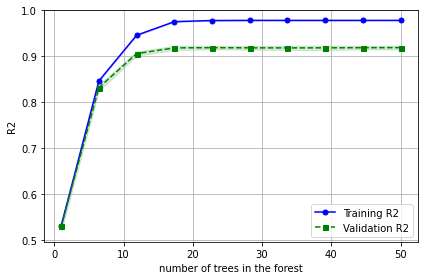

In [16]:
param_range = np.linspace(1, 50, 10)
train_scores, test_scores = validation_curve(estimator=RandomForestRegressor(), X=X_train, y=y_train,
                                             param_name='max_depth', param_range=param_range, cv=5,
                                            scoring='r2')

train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
test_mean, test_std  = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training R2')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='Validation R2')
plt.fill_between(param_range, test_mean + test_std,test_mean - test_std, alpha=0.15, color='green')

plt.grid()

plt.legend(loc='lower right')
plt.xlabel('number of trees in the forest')
plt.ylabel('R2')
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

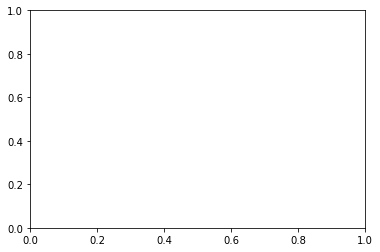

In [17]:
plt.bar(range(0, 60), forest.feature_importances_, alpha=1, align='center')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

#sorted(forest.feature_importances_,reverse=True)

## Feature Selection

In [ ]:
best_features_ind = np.argsort(forest.feature_importances_)[-25:]
best_features = df.columns[best_features_ind]

In [ ]:
print(best_features)

#### Linear Regression FS

## Running Time

In [ ]:
duration = [RT_lr, RT_Lasso, RT_Ridge, RT_ransac,RT_tree, RT_forest,RT_svm]
plt.bar(['LinR','Lasso', 'Ridge','RANSAC','Tree', 'Forest','SVM'], duration, alpha=1, align='center')
plt.ylabel('time in s')
plt.xlabel('Regression Model')
plt.show()